In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import rioxarray
import rasterio

import threading


<Axes: >

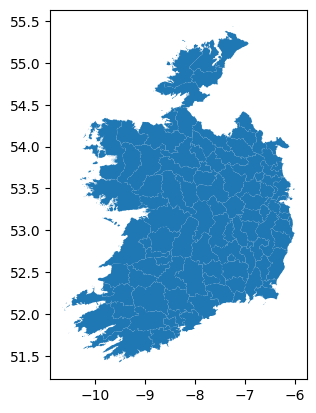

In [2]:
ireland = gpd.read_file("data/geo_data/gadm41_IRL_shp/gadm41_IRL_2.shp")
ireland.plot()

In [3]:
xds = rioxarray.open_rasterio(
    "data/geo_data/gadm41_IRL_shp/raster/SVDNB_npp_20250101-20250131_global_vcmslcfg_v10_c202502181200.cf_cvg.tif",
    chunks=True,
    lock=threading.Lock())

In [4]:
xds.shape

(1, 33601, 86401)

In [5]:
xds

<xarray.DataArray (band: 1, y: 33601, x: 86401)> Size: 6GB
dask.array<open_rasterio-850f969b168d08fcc667a5ee62b8387e<this-array>, shape=(1, 33601, 86401), dtype=uint16, chunksize=(1, 776, 86401), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 691kB -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * y            (y) float64 269kB 75.0 75.0 74.99 74.99 ... -64.99 -65.0 -65.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

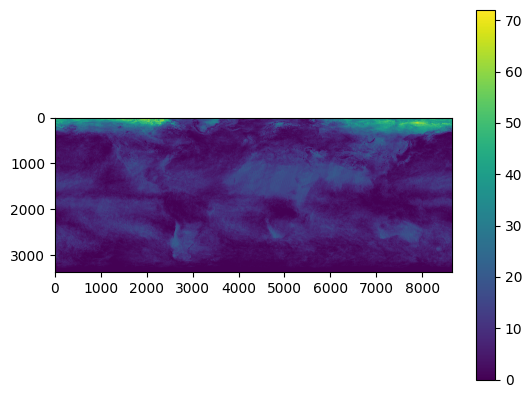

In [6]:
with rasterio.open("data/geo_data/gadm41_IRL_shp/raster/SVDNB_npp_20250101-20250131_global_vcmslcfg_v10_c202502181200.cf_cvg.tif") as src:
    small = src.read(
        1,
        out_shape=(
            src.height // 10,
            src.width // 10
        )
    )

plt.imshow(small)
plt.colorbar()
plt.show()

In [7]:
ireland.head()

,GID_2,GID_0,COUNTRY,GID_1,NAME_1,NL_NAME_1,NAME_2,VARNAME_2,NL_NAME_2,TYPE_2,ENGTYPE_2,CC_2,HASC_2,geometry
0,IRL.1.1_1,IRL,Ireland,IRL.1_1,Carlow,NA,Carlow,NA,NA,Municipal District,Municipal District,NA,NA,"POLYGON ((-6.90837 52.79426, -6.91025 52.79374..."
1,IRL.1.2_1,IRL,Ireland,IRL.1_1,Carlow,NA,Muinebeag,NA,NA,Municipal District,Municipal District,NA,NA,"POLYGON ((-6.96537 52.80945, -6.96682 52.80752..."
2,IRL.1.3_1,IRL,Ireland,IRL.1_1,Carlow,NA,Tullow,NA,NA,Municipal District,Municipal District,NA,NA,"POLYGON ((-6.90837 52.79426, -6.90999 52.79642..."
3,IRL.2.1_1,IRL,Ireland,IRL.2_1,Cavan,NA,Bailieborough-Cootehill,NA,NA,Municipal District,Municipal District,NA,NA,"POLYGON ((-7.31983 54.11353, -7.32103 54.11234..."
4,IRL.2.2_1,IRL,Ireland,IRL.2_1,Cavan,NA,Ballyjamesduff,NA,NA,Municipal District,Municipal District,NA,NA,"POLYGON ((-7.27875 53.954, -7.2775 53.95407, -..."


In [8]:
minx, miny, maxx, maxy = ireland.total_bounds

In [9]:
ireland_xds = xds.rio.clip_box(minx=minx, miny=miny, maxx=maxx, maxy=maxy)

In [10]:
ireland_xds = ireland_xds.rio.clip(ireland.geometry, ireland.crs)


In [11]:
ireland_xds

<xarray.DataArray (band: 1, y: 964, x: 1119)> Size: 2MB
dask.array<astype, shape=(1, 964, 1119), dtype=uint16, chunksize=(1, 736, 1119), chunktype=numpy.ndarray>
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 9kB -10.66 -10.65 -10.65 ... -6.008 -6.004 -6.0
  * y            (y) float64 8kB 55.43 55.43 55.42 55.42 ... 51.43 51.42 51.42
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [12]:
ireland_xds = ireland_xds.compute()


/home/user/Стільниця/python/my projects/uni_vlasov_labs/Uni_labs/.venv/lib/python3.9/site-packages/dask/array/chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


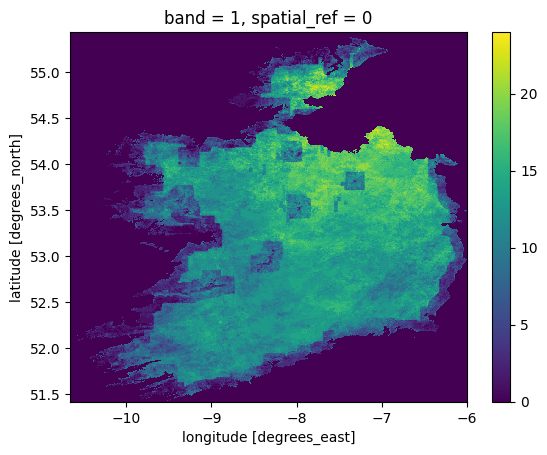

In [13]:
ireland_xds.plot()
plt.show()

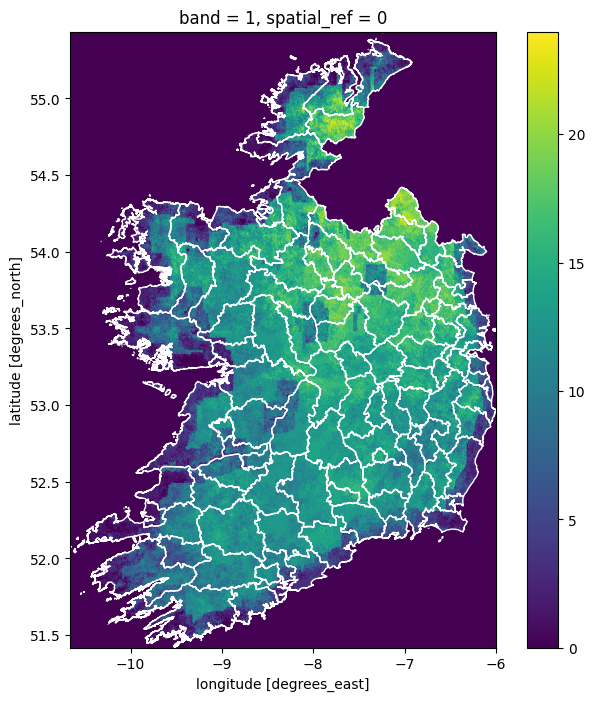

In [15]:
fig, ax = plt.subplots(figsize=(8, 8))

ireland_xds.plot(ax=ax, cmap="viridis")

ireland.boundary.plot(ax=ax, edgecolor="white", linewidth=1)

plt.show()


In [37]:
from rasterstats import zonal_stats


ireland_stats_start = zonal_stats(
    ireland,
    "data/geo_data/gadm41_IRL_shp/raster/SVDNB_npp_20250101-20250131_global_vcmslcfg_v10_c202502181200.cf_cvg.tif",              # or the clipped raster file
    stats=["mean"],
    geojson_out=False,
    nodata=0
)

ireland_stats_end = zonal_stats(
    ireland,
    "data/geo_data/gadm41_IRL_shp/raster/SVDNB_npp_20250901-20250930_global_vcmslcfg_v10_c202510142200.cf_cvg.tif",              # or the clipped raster file
    stats=["mean"],
    geojson_out=False,
    nodata=0
)


In [ ]:
ireland["avg_luminosity_start"] = list(map(lambda x: x["mean"], ireland_stats_start))
ireland["avg_luminosity_end"] = list(map(lambda x: x["mean"], ireland_stats_end))

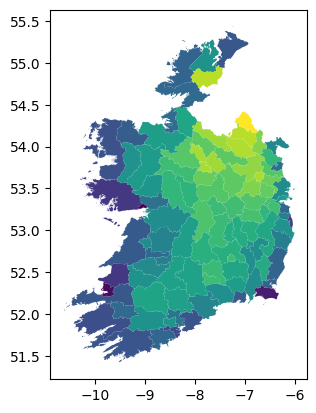

In [39]:
ireland.plot("avg_luminosity_start")
plt.show()

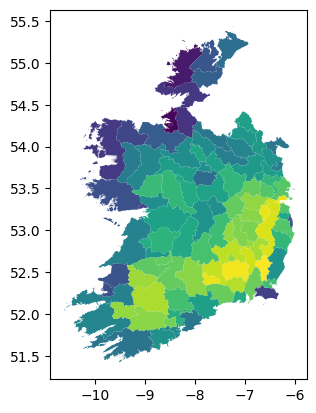

In [40]:
ireland.plot("avg_luminosity_end")
plt.show()